In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [2]:
def snap_bond_graph(snap):
    """
    Given a snapshot from a trajectory return an array
    corresponding to the molecule index of each particle 
    
    Parameters
    ----------
    snap : gsd.hoomd.Snapshot

    Returns
    -------
    numpy array (N_particles,)
    
    """
    bond_graph = csr_matrix(
        (np.ones(snap.bonds.N), (snap.bonds.group[:,0],snap.bonds.group[:,1])),
        shape=(snap.particles.N,snap.particles.N)
    )
    n_components, labels = connected_components(csgraph=bond_graph, directed=False)
    return labels

def not_same_molecule(i, j, molecules):
    """
    Returns true if particle indices i and j are not in the same molecule
    
    Parameters
    ----------
    i,j : int, particle indices
    molecules : numpy array (N_particles,),  array corresponding to the 
                molecule index of each particle

    Returns
    -------
    bool
    """
    if molecules[i] == molecules[j]:
        return False
    return True

def is_AB(i, j, type_A, type_B):
    """
    Returns true if particle indices i and j are types A-B or B-A 

    Parameters
    ----------
    i,j : int, particle indices
    type_A, type_B : numpy array of bools (N_particles,), array of if particle is type A or B

    Returns
    -------
    bool
    """
    return (type_A[i] and type_B[j]) or (type_A[j] and type_B[i])

def gsd_rdf(
    gsdfile, A_name, B_name, start=0, stop=None, rmax=None, rmin=0, bins=50, exclude_bonded=True
):
    """
    This function calculates the radial distribution function given
    a gsd file and the names of the particles. By default it will calculate
    the rdf for the entire the trajectory.

    Parameters
    ----------
    gsdfile : str, filename of the gsd trajectory
    A_name, B_name : str, name(s) of particles between which to calculate the rdf
                     (found in gsd.hoomd.Snapshot.particles.types)
    start : int, which frame to start accumulating the rdf (default 0)
            (negative numbers index from the end)
    stop : int, which frame to stop accumulating the rdf (default None)
           If none is given, the function will default to the last frame.
    rmax : float, maximum radius to consider. (default None)
           If none is given, it'll be the minimum box length / 4
    bins : int, number of bins to use when calculating the distribution.
    exclude_bonded : bool, whether to remove particles in same molecule from the neighborlist
                     (default True)
                     
    NOTE: It is assumed that the bonding and the number of particles does not change during the simulation

    Returns
    -------
    freud.density.RDF
    """
    with open(gsdfile, "rb") as file:
        f = gsd.pygsd.GSDFile(file)
        t = gsd.hoomd.HOOMDTrajectory(f)
        snap = t[0]
        if start < -len(t):
            raise IndexError(
                    f"Can't index beyond first frame: {len(t)} frames in gsd file"
                    )
        if rmax is None:
            rmax = max(snap.configuration.box[:3]) * 0.45

        rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)
        
        if exclude_bonded:
            molecules = snap_bond_graph(snap)
        
        if stop is None:
            stop = len(t) - 1
        if start < 0:
            start += len(t)
            
        for frame in range(start, stop):
            snap = t[frame]

            aq = freud.locality.AABBQuery.from_system(snap)
            nlist = aq.query(snap.particles.position, {"r_max": rmax}).toNeighborList()
            
            type_A = snap.particles.typeid == snap.particles.types.index(A_name)
            if A_name != B_name:
                type_B = snap.particles.typeid == snap.particles.types.index(B_name)
            else:
                type_B = type_A
            
            nlist_zip = zip(nlist.point_indices, nlist.query_point_indices)
            filter_types = [is_AB(i,j,type_A,type_B) for i,j in nlist_zip]
            nlist.filter(filter_types)
            
            if exclude_bonded:  
                nlist_zip = zip(nlist.point_indices, nlist.query_point_indices)
                filter_molecules = [
                    not_same_molecule(i, j, molecules) for i,j in nlist_zip
                ]
                nlist.filter(filter_molecules)
                
            rdf.compute(aq, neighbors=nlist, reset=False)
            return rdf

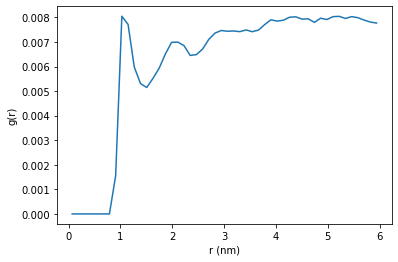

CPU times: user 2min 57s, sys: 8.41 s, total: 3min 5s
Wall time: 1min 47s


In [3]:
%%time
gsdfile = "data/ptb7-5mers.gsd"
A_name = "ss"
B_name = "ss"

rdf = gsd_rdf(gsdfile, A_name, B_name, rmin=0.01, rmax=6)

plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()

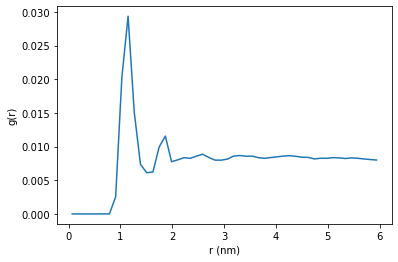

CPU times: user 3min 1s, sys: 6.92 s, total: 3min 8s
Wall time: 1min 45s


In [4]:
%%time
A_name = "ss"
B_name = "ss"

rdf = gsd_rdf(gsdfile, A_name, B_name, rmin=0.01, rmax=6, exclude_bonded=False)

plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()